In [ ]:
import torch
import torch.nn as nn
import numpy as np
import torchvision.datasets
import torchvision.utils as vutils
from torchvision import transforms, models
from torch.utils.data import Subset
from torch.utils.data import DataLoader
from torch.nn.modules.flatten import Flatten
import time, copy
import matplotlib.pyplot as plt
import sklearn.metrics as metrics


# Configuración del dispositivo (si es posible, entrenar el modelo en la GPU, el proceso será mucho más rápido)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
image_size = 64

In [ ]:
transform = transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ])
flowers_train = torchvision.datasets.Flowers102('', split = "train",  transform =transform, download=True)

100%|██████████| 344862509/344862509 [00:15<00:00, 22886590.18it/s]


Extracting flowers-102/102flowers.tgz to flowers-102


100%|██████████| 502/502 [00:00<00:00, 617279.57it/s]


100%|██████████| 14989/14989 [00:00<00:00, 13522999.07it/s]


In [ ]:
#para descargar de la página
#flowers_train = torchvision.datasets.Flowers102('', split = "train",  transform =transform_train, download=True)
#flowers_val = torchvision.datasets.Flowers102('', split='val', transform = transform_val, download=True)
#flowers_test = torchvision.datasets.Flowers102('', split='test', transform = transform_test, download=True)


In [ ]:
flowers_train = torchvision.datasets.ImageFolder(root='/content/drive/MyDrive/Dataset/Flowers/train', transform =transform)
flowers_val = torchvision.datasets.ImageFolder(root='/content/drive/MyDrive/Dataset/Flowers/valid', transform =transform)
flowers_test = torchvision.datasets.ImageFolder(root='/content/drive/MyDrive/Dataset/Flowers/test', transform =transform)

In [ ]:
# Crearemos DataLoaders igual que antes, con un tamaño de lotes de 100
batch_size = 64
dataloaders = {'train': DataLoader(flowers_train, batch_size=64),
               'val': DataLoader(flowers_val, batch_size=32),
               'test': DataLoader(flowers_test, shuffle=True, batch_size=20)}

dataset_sizes = {'train': len(flowers_train),
                 'val': len(flowers_val),
                 'test': len(flowers_test)}
print(f'dataset_sizes = {dataset_sizes}')

dataset_sizes = {'train': 688, 'val': 71, 'test': 83}


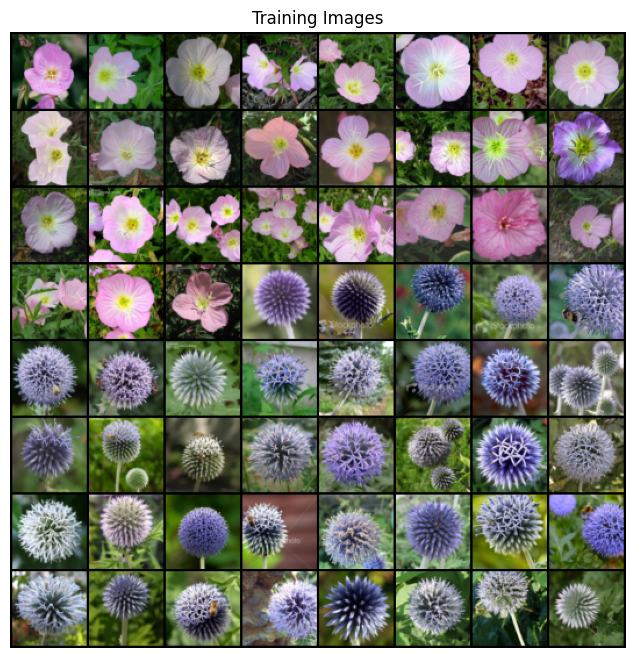

In [ ]:
# Función de visualización extraída de: https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html

# Trazar algunas imágenes de entrenamiento
real_batch = next(iter(dataloaders["train"]))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:70], padding=2, normalize=True).cpu(),(1,2,0)))

In [ ]:
#realizamos una transferencia del modelo

modelT = models.vgg11(pretrained=True, progress=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG11_Weights.IMAGENET1K_V1`. You can also use `weights=VGG11_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg11-8a719046.pth" to /root/.cache/torch/hub/checkpoints/vgg11-8a719046.pth
100%|██████████| 507M/507M [00:07<00:00, 73.5MB/s]


In [ ]:
modelT

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU(inplace=True)
    (13): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU(inplace=True)
    (15): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
 

In [ ]:
#Congelamos los pesos de la red.
for param in modelT.parameters(): #modelT.features.parameters():
  param.requires_grad = False

In [ ]:
#Cambiamos la capa d clasificación y la adecuamos a nuestro objetivo
clasificacion = nn.Sequential(
    nn.Linear(in_features=25088, out_features=4096, bias=True),
    nn.ReLU(),
    nn.Dropout(p=0.5),
    nn.Linear(in_features=4096, out_features=2048, bias=True),
    nn.ReLU(),
    nn.Dropout(p=0.5),
    nn.Linear(in_features=2048, out_features=15, bias=True) #,
    #nn.LogSoftmax(dim=1)
)

modelT.classifier = clasificacion
modelT.to(device)
modelT

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU(inplace=True)
    (13): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU(inplace=True)
    (15): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
 

In [ ]:
# Primero, definir el número total de clases:
flo_labels = set()
for _, labels in dataloaders["train"]:
    for label in labels:
        flo_labels.add(label.item())
print(len(flo_labels))
print(flo_labels)

15
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14}


In [ ]:
# Extraído de https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

def train_classification_model(model, dataloaders, dataset_sizes, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict()) # Almacenar los mejores pesos por separado
    best_acc = 0.0
    best_epoch = 0

   # Cada ciclo tiene una fase de entrenamiento, validación y prueba
    phases = ['train', 'val', 'test']

    # Hacer un seguimiento de la evolución de la pérdida durante el entrenamiento
    training_curves = {}
    for phase in phases:
        training_curves[phase+'_loss'] = []
        training_curves[phase+'_acc'] = []

    for epoch in range(num_epochs):
        print(f'\nEpoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        for phase in phases:
            if phase == 'train':
                model.train()  # Configurar el modelo en modo de entrenamiento
            else:
                model.eval()   # Configurar el modelo en modo de evaluación

            running_loss = 0.0
            running_corrects = 0

           # Iterar con los datos
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Poner a cero los gradientes de los parámetros
                optimizer.zero_grad()

                # Método forward
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, predictions = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # Método backward y actualización de los pesos solo si está en la fase de entrenamiento
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Estadísticas
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(predictions == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            training_curves[phase+'_loss'].append(epoch_loss)
            training_curves[phase+'_acc'].append(epoch_acc)

            print(f'{phase:5} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # Hacer una copia profunda del modelo si ha alcanzado la mayor precisión
            if phase == 'val' and epoch_acc > best_acc:
              best_epoch = epoch
              best_acc = epoch_acc
              best_model_wts = copy.deepcopy(model.state_dict())

    time_elapsed = time.time() - since
    print(f'\nTraining complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f} at epoch {best_epoch}')

    # Cargar los mejores pesos del modelo
    model.load_state_dict(best_model_wts)

    return model, training_curves

In [ ]:
learning_rate1 = 0.001
num_epochs1 = 10

# Pérdida y optimizador para el modelo
criterion1 = nn.CrossEntropyLoss() # Utilizar CrossEntropyLoss para la clasificación
optimizer1 = torch.optim.Adam(modelT.parameters(), lr=learning_rate1)
scheduler1 = torch.optim.lr_scheduler.ExponentialLR(optimizer1, gamma=0.95)


# Entrenamos el modelo y además guardamos los resultados del entrenamiento para poder visualizarlos
model, training_curves = train_classification_model(modelT, dataloaders, dataset_sizes,
                                     criterion1, optimizer1, scheduler1, num_epochs=num_epochs1)


Epoch 1/10
----------
train Loss: 10.8690 Acc: 0.0073
val   Loss: 2.6473 Acc: 0.2394
test  Loss: 2.6369 Acc: 0.1807

Epoch 2/10
----------
train Loss: 2.8481 Acc: 0.0174
val   Loss: 2.3475 Acc: 0.3944
test  Loss: 2.3504 Acc: 0.4096

Epoch 3/10
----------
train Loss: 2.1414 Acc: 0.3285
val   Loss: 1.9088 Acc: 0.3944
test  Loss: 1.8320 Acc: 0.4096

Epoch 4/10
----------
train Loss: 1.6061 Acc: 0.4404
val   Loss: 1.3783 Acc: 0.6197
test  Loss: 1.4078 Acc: 0.5904

Epoch 5/10
----------
train Loss: 1.1645 Acc: 0.5843
val   Loss: 0.9353 Acc: 0.7183
test  Loss: 1.0782 Acc: 0.7590

Epoch 6/10
----------
train Loss: 0.8459 Acc: 0.7049
val   Loss: 0.7822 Acc: 0.7746
test  Loss: 0.9357 Acc: 0.7590

Epoch 7/10
----------
train Loss: 0.5693 Acc: 0.7936
val   Loss: 0.7350 Acc: 0.7746
test  Loss: 0.8753 Acc: 0.7952

Epoch 8/10
----------
train Loss: 0.4379 Acc: 0.8430
val   Loss: 0.5823 Acc: 0.8451
test  Loss: 0.7866 Acc: 0.8313

Epoch 9/10
----------
train Loss: 0.3162 Acc: 0.8866
val   Loss: 0.630

In [ ]:
def plot_training_curves(training_curves,
                         phases=['train', 'val', 'test'],
                         metrics=['loss','acc']):
    epochs = list(range(len(training_curves['train_loss'])))
    for metric in metrics:
        plt.figure()
        plt.title(f'Training curves - {metric}')
        for phase in phases:
            key = phase+'_'+metric
            if key in training_curves:
                if metric == 'acc':
                    plt.plot(epochs, [item.detach().cpu() for item in training_curves[key]])
                else:
                    plt.plot(epochs, training_curves[key])
        plt.xlabel('epoch')
        plt.legend(labels=phases)

def classify_predictions(model, device, dataloader):
    model.eval()   # Configurar el modelo en modo de evaluación
    all_labels = torch.tensor([])
    all_scores = torch.tensor([])
    all_preds = torch.tensor([])
    for inputs, labels in dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = torch.softmax(model(inputs),dim=1)
        _, preds = torch.max(outputs, 1)
        scores = outputs[:,1]
        all_labels = torch.cat((all_labels, labels.detach().cpu()), 0)
        all_scores = torch.cat((all_scores, scores.detach().cpu()), 0)
        all_preds = torch.cat((all_preds, preds.detach().cpu()), 0)
    return all_preds, all_labels, all_scores

def plot_cm(model, device, dataloaders, phase='test'):
    class_labels = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9,10,11,12,13,14]
    preds, labels, scores = classify_predictions(model, device, dataloaders[phase])

    cm = metrics.confusion_matrix(labels, preds)
    disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
    ax = disp.plot().ax_
    ax.set_title('Confusion Matrix -- counts')

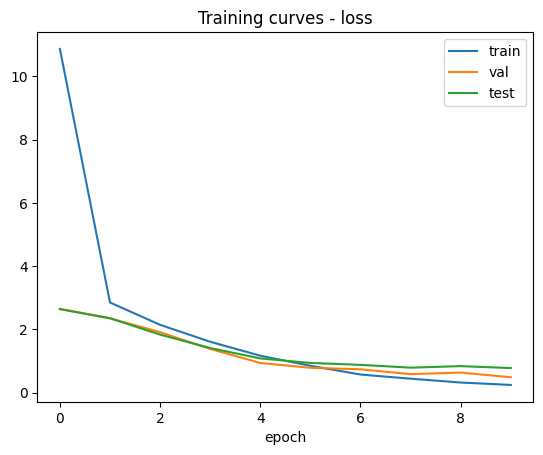

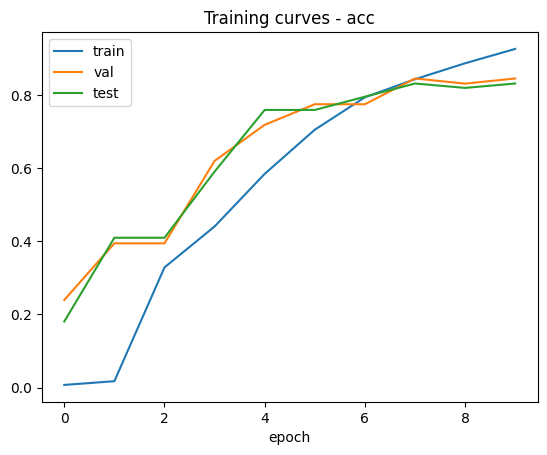

In [ ]:
plot_training_curves(training_curves, phases=['train', 'val', 'test'])

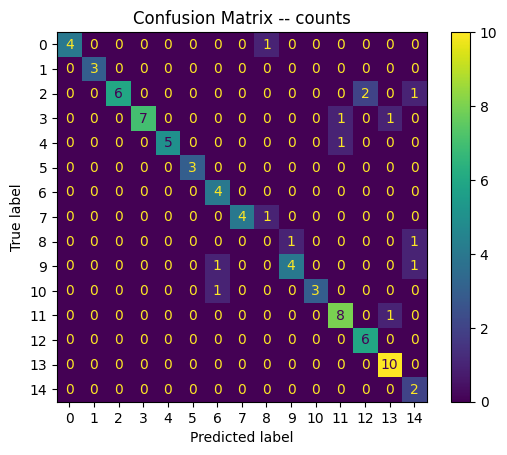

In [ ]:
res = plot_cm(model, device, dataloaders, phase='test')